<a href="https://colab.research.google.com/github/iris-kurapaty/GradCam_Exp/blob/main/ERA_Assignment_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
!git clone https://github.com/iris-kurapaty/GradCam_Exp.git

Cloning into 'GradCam_Exp'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 34 (delta 9), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (34/34), 950.93 KiB | 3.30 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [4]:
%cd '/content/GradCam_Exp/src'

/content/GradCam_Exp/src


In [11]:
!pip install torch-lr-finder

In [24]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38247 sha256=ba0d2553f9c02b814d76124d6840174112a964cfb524c7431e9a204274350365
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [5]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchsummary import summary
from tqdm import tqdm
import albumentations as A
from torch_lr_finder import LRFinder
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import OneCycleLR
from transform import *
from model import *
from utils import *
from dataset import cifar10Dataset, get_loader
from mytrain import *
from mytest import test
from main import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [6]:
SEED = 1

# CUDA?
use_cuda = torch.cuda.is_available()
print("CUDA Available?", use_cuda)

# For reproducibility
torch.manual_seed(SEED)

if use_cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


In [7]:
train_transforms = get_train_transforms()
test_transforms = get_test_transforms()
train_data = cifar10Dataset('./data', train=True, download=True, transform=train_transforms) #
test_data = cifar10Dataset('./data', train=False, download=True, transform=test_transforms) #

100%|██████████| 170498071/170498071 [00:13<00:00, 13049599.27it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [8]:
# train dataloader and test loader
batch_size = 512
train_loader, test_loader = get_loader(train_data, test_data, batch_size, use_cuda)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Visualizing Some Images

# Model Params



In [10]:
from model import ResNet18

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.51E-02


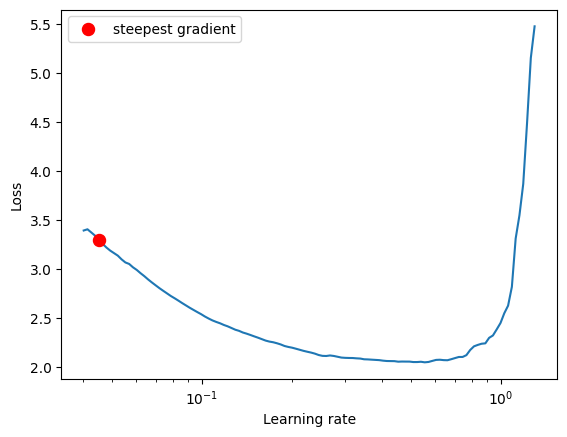

In [12]:
optimizer, criterion = get_lr_value(model, device, train_loader)

# Training and Testing

In [19]:

train_losses_t = []
test_losses_t = []
train_acc_t = []
test_acc_t = []
lrs = []
EPOCHS = 20

scheduler = OneCycleLR(optimizer, max_lr=4.51E-02,steps_per_epoch=len(train_loader),
                       epochs=EPOCHS,pct_start=6/EPOCHS, div_factor=100, three_phase=False,
                       final_div_factor=100,anneal_strategy='linear')

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_losses, train_acc = train(model, device, train_loader, optimizer, epoch, scheduler, criterion)
    train_losses_t += train_losses
    train_acc_t.append(train_acc)
    test_losses, test_acc = test(model, device, test_loader, criterion)
    test_losses_t += test_losses
    test_acc_t.append(test_acc)

EPOCH: 0


  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=1.1179500818252563 Batch_id=97 Accuracy=61.24: 100%|██████████| 98/98 [00:45<00:00,  2.15it/s]



Test set: Average loss: 0.0036, Accuracy: 4657/10000 (46.57%)

EPOCH: 1


Loss=0.9468833208084106 Batch_id=97 Accuracy=65.27: 100%|██████████| 98/98 [00:43<00:00,  2.23it/s]



Test set: Average loss: 0.0022, Accuracy: 6010/10000 (60.10%)

EPOCH: 2


Loss=0.7707880735397339 Batch_id=97 Accuracy=71.04: 100%|██████████| 98/98 [00:45<00:00,  2.18it/s]



Test set: Average loss: 0.0028, Accuracy: 5625/10000 (56.25%)

EPOCH: 3


Loss=0.7596230506896973 Batch_id=97 Accuracy=72.37: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]



Test set: Average loss: 0.0029, Accuracy: 5785/10000 (57.85%)

EPOCH: 4


Loss=0.8025961518287659 Batch_id=97 Accuracy=73.34: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]



Test set: Average loss: 0.0032, Accuracy: 5401/10000 (54.01%)

EPOCH: 5


Loss=0.8257538676261902 Batch_id=97 Accuracy=72.53: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]



Test set: Average loss: 0.0046, Accuracy: 4842/10000 (48.42%)

EPOCH: 6


Loss=0.7895770072937012 Batch_id=97 Accuracy=72.87: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]



Test set: Average loss: 0.0025, Accuracy: 5878/10000 (58.78%)

EPOCH: 7


Loss=0.759487509727478 Batch_id=97 Accuracy=73.95: 100%|██████████| 98/98 [00:43<00:00,  2.25it/s]



Test set: Average loss: 0.0041, Accuracy: 4835/10000 (48.35%)

EPOCH: 8


Loss=0.7694546580314636 Batch_id=97 Accuracy=75.10: 100%|██████████| 98/98 [00:43<00:00,  2.26it/s]



Test set: Average loss: 0.0023, Accuracy: 6484/10000 (64.84%)

EPOCH: 9


Loss=0.729156494140625 Batch_id=97 Accuracy=76.29: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]



Test set: Average loss: 0.0021, Accuracy: 6555/10000 (65.55%)

EPOCH: 10


Loss=0.5621457695960999 Batch_id=97 Accuracy=76.94: 100%|██████████| 98/98 [00:43<00:00,  2.27it/s]



Test set: Average loss: 0.0022, Accuracy: 6508/10000 (65.08%)

EPOCH: 11


Loss=0.649637758731842 Batch_id=97 Accuracy=77.95: 100%|██████████| 98/98 [00:42<00:00,  2.28it/s]



Test set: Average loss: 0.0024, Accuracy: 6070/10000 (60.70%)

EPOCH: 12


Loss=0.5594027638435364 Batch_id=97 Accuracy=79.17: 100%|██████████| 98/98 [00:43<00:00,  2.25it/s]



Test set: Average loss: 0.0023, Accuracy: 6786/10000 (67.86%)

EPOCH: 13


Loss=0.616747260093689 Batch_id=97 Accuracy=80.36: 100%|██████████| 98/98 [00:43<00:00,  2.27it/s]



Test set: Average loss: 0.0018, Accuracy: 6944/10000 (69.44%)

EPOCH: 14


Loss=0.4961306154727936 Batch_id=97 Accuracy=81.47: 100%|██████████| 98/98 [00:42<00:00,  2.28it/s]



Test set: Average loss: 0.0017, Accuracy: 7300/10000 (73.00%)

EPOCH: 15


Loss=0.5125120282173157 Batch_id=97 Accuracy=82.76: 100%|██████████| 98/98 [00:43<00:00,  2.27it/s]



Test set: Average loss: 0.0011, Accuracy: 8101/10000 (81.01%)

EPOCH: 16


Loss=0.4253539443016052 Batch_id=97 Accuracy=84.38: 100%|██████████| 98/98 [00:43<00:00,  2.28it/s]



Test set: Average loss: 0.0011, Accuracy: 8175/10000 (81.75%)

EPOCH: 17


Loss=0.4377320110797882 Batch_id=97 Accuracy=86.20: 100%|██████████| 98/98 [00:42<00:00,  2.30it/s]



Test set: Average loss: 0.0009, Accuracy: 8426/10000 (84.26%)

EPOCH: 18


Loss=0.3760032653808594 Batch_id=97 Accuracy=88.50: 100%|██████████| 98/98 [00:43<00:00,  2.26it/s]



Test set: Average loss: 0.0007, Accuracy: 8736/10000 (87.36%)

EPOCH: 19


Loss=0.3061695694923401 Batch_id=97 Accuracy=91.15: 100%|██████████| 98/98 [00:42<00:00,  2.28it/s]



Test set: Average loss: 0.0006, Accuracy: 8978/10000 (89.78%)



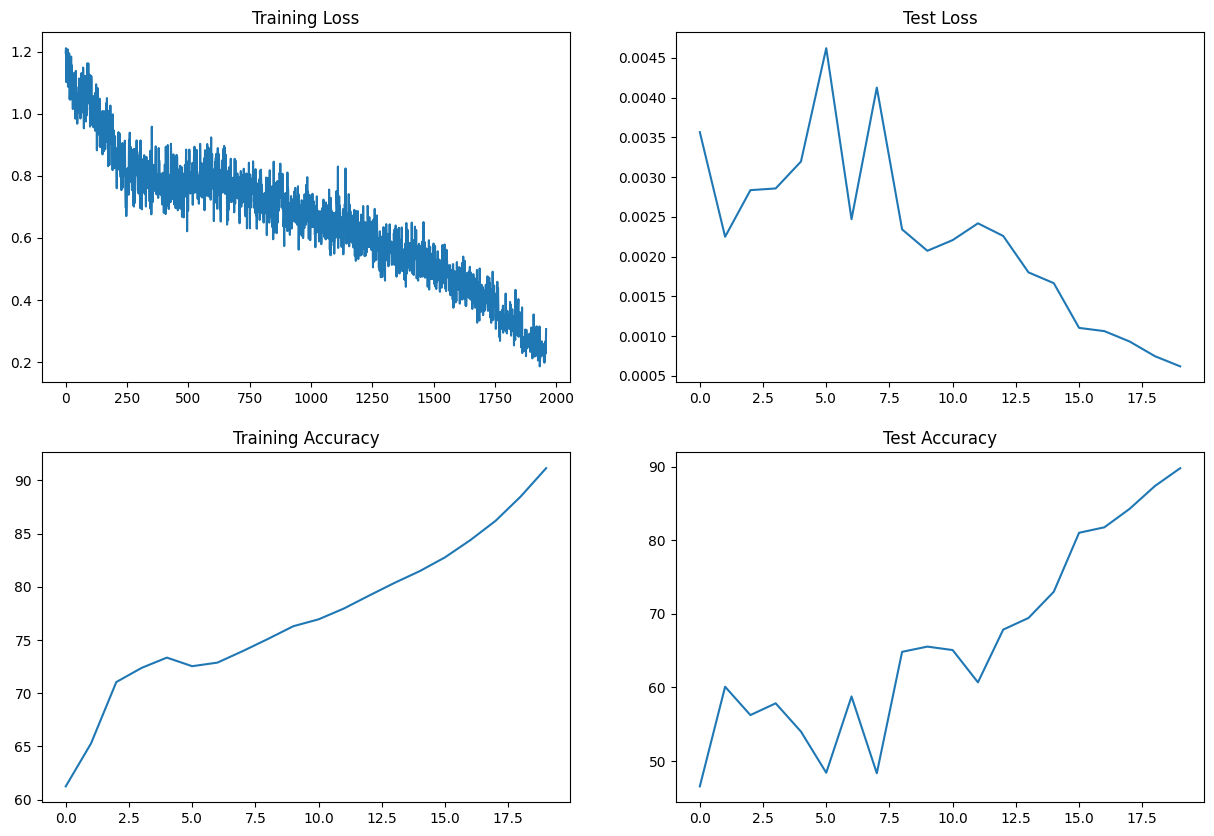

In [21]:
plot_loss_acc(train_losses_t, train_acc_t, test_losses_t, test_acc_t)

In [22]:
incorrect_examples, incorrect_labels,incorrect_pred = mis_classified_images(model, device, test_loader)

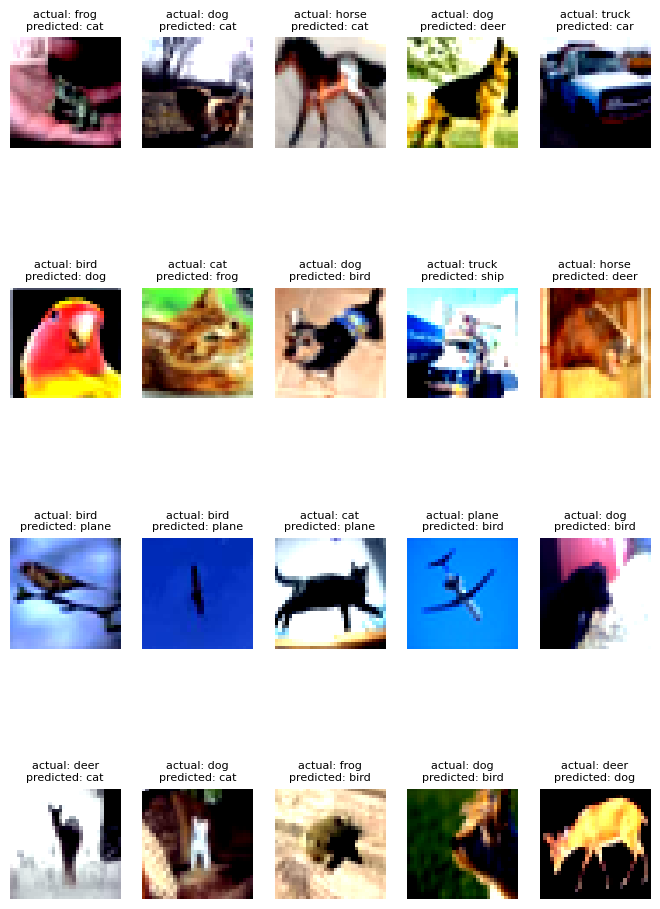

In [168]:
plot_images(incorrect_examples, incorrect_labels,incorrect_pred, num_images= 20)

In [ ]:
## GRADCAM

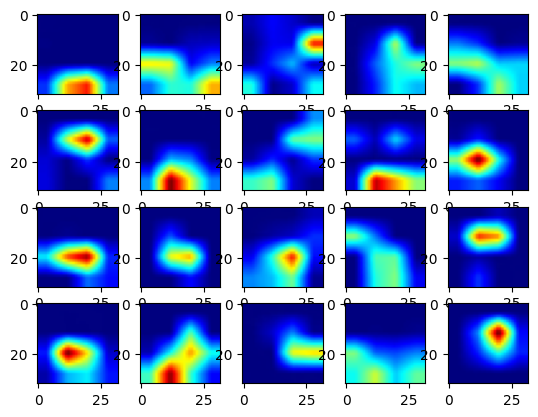

In [126]:
display_gradcam(model, incorrect_examples, 20, 'deer')